In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import pathlib
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import lightning
import lightning.pytorch.callbacks as callbacks

import poregen.models

In [34]:
MAINFOLDER = pathlib.Path("../..")  # This leads to the main folder
DATAFOLDER = MAINFOLDER/"saveddata"  # This leads to the data folder
MODELSFOLDER = MAINFOLDER/"savedmodels" #This leads to the models folder
EXTERNALDATAFOLDER = DATAFOLDER/'external'  # This leads to the external data folder

In [35]:
class UnlabeledMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        x, _ = self.mnist_dataset[idx]
        return x

mnist_dataset = torchvision.datasets.MNIST(EXTERNALDATAFOLDER,
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

unlabeled_mnist_dataset = UnlabeledMNISTDataset(mnist_dataset)


In [36]:
batch_size = 16
p_split = 0.8
num_workers = multiprocessing.cpu_count() - 2

num_train_dataset = int(len(unlabeled_mnist_dataset)*p_split)
num_valid_dataset = len(unlabeled_mnist_dataset) - num_train_dataset
train_dataset, val_dataset = torch.utils.data.random_split(unlabeled_mnist_dataset,
                                                           [num_train_dataset, num_valid_dataset])
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)

In [37]:
model = poregen.models.PUNetUncond(32, dropout=0.2)
scheduler = poregen.models.DDPMScheduler()
module = poregen.models.DDPMModule(model,
                                   scheduler,
                                   conditional=False,
                                   loss_type="huber",
                                   loss_scaling="constant",
                                   loss_scale_factor=1)

In [38]:
checkpoint_callback = callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODELSFOLDER/"tutorial-0002-berea",
    filename='sample-mnist-{epoch:02d}-{val_loss:.6f}',
    save_top_k=1,
    mode='min',
)


In [39]:
module.optimizer = torch.optim.Adam(module.parameters(),
                                    lr=2*1e-5)
module.lr_scheduler = None

In [40]:
trainer = lightning.Trainer(max_epochs=5,
                            callbacks=[checkpoint_callback])
trainer.fit(model=module,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dfnaiff/miniconda3/envs/ddpmenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/dfnaiff/miniconda3/envs/ddpmenv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [41]:
module.model.eval()
module.model.to("cuda")
sampler = poregen.models.DDPMSampler(module.model, 
                                     module.scheduler,
                                     shape=[1, 28, 28],
                                     noise_type=2)

In [42]:
samples_from_ddpm = sampler.sample(nsamples=16, device="cuda").cpu()


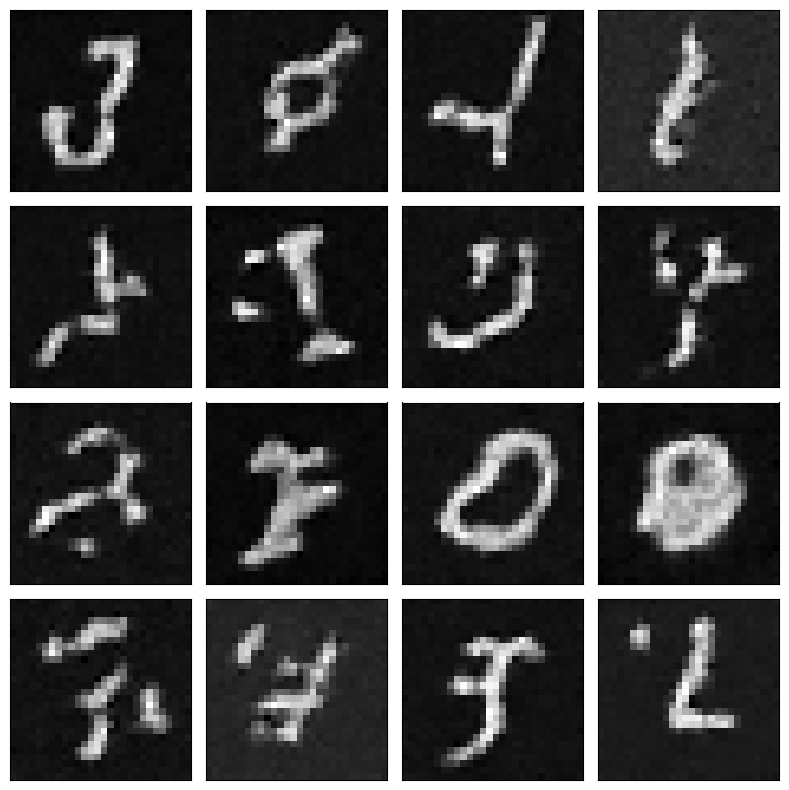

In [46]:
# Set up the matplotlib figure and axes
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # Select the ith image from the batch
    img = samples_from_ddpm[i].squeeze()  # Remove the channel dimension

    # Display the image
    ax.matshow(img, cmap='gray')

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()